# Select Open-Source LLM for Fine-Tuning
In this notebook we are comparing accuracy of the following LLM candidates on the gorund truth dataset which was created in <NOTEBOOK NAME>:
* Mistral 7B
* llama-v3-8b-instruct
* gemma-7b-it
* qwen-2-7b


# 1. Initializer

In [ ]:
!pip install boto3
from IPython.display import clear_output
clear_output()

In [ ]:
import os
if 's3-operator' in os.listdir():
  pass
else:
# this will install a library to help with reading/saving files from/to s3
  !git clone https://github.com/aguille-vert/s3-operator

import sys
sys.path.append('/content/s3-operator')

import s3_operator as oper

In [ ]:
import json
import boto3
from time import time
import pandas as pd
import numpy as np
from io import BytesIO
from PIL import Image
import requests
from collections import defaultdict
from random import choice, choices
import re
from datetime import datetime, timedelta
from joblib import Parallel, delayed, parallel_backend, dump, load
from random import randint, choice
from pprint import pprint
from time import sleep
import base64

## clients and tokens

In [ ]:
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_KEY')
MISTRAL_API_KEY = userdata.get('MISTRAL_API_KEY')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
FIREWORKS_API_KEY = userdata.get('FIREWORKS_API_KEY')

AWS_BRG_ACCESS_KEY = userdata.get('AWS_BRG_ACCESS_KEY')
AWS_BRG_SECRET_ACCESS_KEY = userdata.get('AWS_BRG_SECRET_ACCESS_KEY')

s3_client = boto3.client('s3',
            aws_access_key_id = AWS_BRG_ACCESS_KEY,
            aws_secret_access_key = AWS_BRG_SECRET_ACCESS_KEY)


In [ ]:
BUCKET = 'bergena-invoice-parser'

# 2. Functions

In [ ]:
# per million tokens

model_pricing = {

                 'gpt-4o': {'prompt_tokens':5,
                                          'completion_tokens':15},

                  'gpt-3.5-turbo-0125': {'prompt_tokens' : 0.5,
                                              'completion_tokens': 1.5},
                  'gpt-4-turbo': {'prompt_tokens':10,
                                          'completion_tokens':30},
                  # https://mistral.ai/technology/:
                'open-mistral-7b' : {
                    'prompt_tokens' : 0.25,
                    'completion_tokens' : 0.25
                    },
                  'open-mixtral-8x7b' : {
                                        'prompt_tokens' : 0.7,
                                        'completion_tokens' : 0.7
                                        },
                  'open-mixtral-8x22b' : {
                                        'prompt_tokens' : 2,
                                        'completion_tokens' : 6
                                        },
                 # fireworks.ai:
                 'llama-v3-8b-instruct' : {
                                        'prompt_tokens' : 0.2,
                                        'completion_tokens' : 0.2
                                        },
                 'mistral-7b-instruct-v3': {
                                        'prompt_tokens' : 0.2,
                                        'completion_tokens' : 0.2
                                        },
                 'gemma-7b-it':         {
                                        'prompt_tokens' : 0.2,
                                        'completion_tokens' : 0.2
                                        },

                  # groq.com 8,192 tokens:
                  'llama3-8b-8192' : {
                                        'prompt_tokens' : 0.005,
                                        'completion_tokens' : 0.010
                                        },
                  'mixtral-8x7b-32768' : {
                                        'prompt_tokens' : 0.27,
                                        'completion_tokens' : 0.27
                                        },
                  'llama3-70b-8192' : {
                                        'prompt_tokens' : 0.59,
                                        'completion_tokens' : 0.79
                                        },

                }




def get_text_completion(model, prompt, api, api_key,
                   temperature = 0.1,
                   max_tokens = 1024,
                        timeout=60):

  apis = {'groq': 'https://api.groq.com/openai/v1/chat/completions',
          'openai' : 'https://api.openai.com/v1/chat/completions',
          'mistral' : 'https://api.mistral.ai/v1/chat/completions',
          'nvidia' : 'https://integrate.api.nvidia.com/v1/chat/completions',
          'fireworks':'https://api.fireworks.ai/inference/v1/chat/completions'
          }

  url = apis.get(api)

  headers = {"Content-Type": "application/json",
          "Accept": "application/json",
          "Authorization": f"Bearer {api_key}"}


  messages = [
                {
                    "role": "user",
                    "content": json.dumps(prompt),
                },
                # {
                #   "role": "system",
                #   "content": "you are a helpful accountant."
                # }
              ]
  if api == 'fireworks':
    model = f"accounts/fireworks/models/{model}"
  payload = {
          "model": model,
          "messages": messages,
          "max_tokens" : max_tokens,
          "response_format" : {"type": "json_object"},
          "temperature":temperature,
          # "stop" : '<END>'
        }


  return requests.post(url, json=payload, headers=headers, timeout=timeout)


def get_totals(completion):
  summary = completion['Summary_fields']
  gross_amount = float(summary['gross_amount'])
  line_items = completion['Line_items']
  line_items_sum = sum([float(i['spot_amount']) for i in line_items])
  return gross_amount, line_items_sum

def get_tokens_usage(completion):

  try:
    # completion = json.loads(completion)
    usage = completion['usage']
    prompt_tokens = usage['prompt_tokens']
    completion_tokens = usage['completion_tokens']
  except:
    prompt_tokens = None
    completion_tokens = None
  return prompt_tokens, completion_tokens





# 3. df_true: ground truth dataset
the gorund truth ds was created in  this Colab notebook: [create_truth_dataset.ipynb](https://github.com/aguille-vert/trump-biden-ads/blob/main/notebooks/create_truth_dataset.ipynb)  

GPT-4o was prompted to retrieve:
* invoice gross amounts
* Spot amounts for all ad spots in the invoice  

After that a quality functionw as used to compute sum total of all extracted spots in each invoice  

ground truth dataset includes all file names of invoices where retrieved gross  amount equals sum_totals of all retrieved spot amounts

```
`# This is formatted as code`
```



the dataset is available for download at [true_df.parquet](https://github.com/aguille-vert/trump-biden-ads/blob/main/data/true_df.parquet)

In [ ]:

key = 'datasets/FCC/completions/april_2024_biden_invoices/true_df.parquet'
df_true = oper.pd_read_parquet(s3_client,
                               BUCKET,
                               key)
df_true.shape

(142, 4)

In [ ]:
df_true

,file_name,gross_amount,line_sum,text
1,Biden for President 6065165 invoice 10286532,2440.0,2440.0,FOX66 REMIT TO Sinclair Broadcast c/c WSMH Ad...
2,78175-5224040008 Biden for President est 11600...,1350.0,1350.0,INVOICE Page 1 of 1\n abc 12 WJRT-TV 2302 ...
3,Biden for President 6030682 invoice 10285193,1800.0,1800.0,FOX66 REMIT TO Sinclair Broadcast d/a WSMH PO...
4,Biden for President 6030845 invoice 10285200,188.0,188.0,FOX66 REMIT TO Sinclair Broadcast c/o WSMH Ad...
5,6031177 Invoice,950.0,950.0,Weekty/Irregular 3/25/2024 -3/31/...
...,...,...,...,...
138,BIDEN FOR PRESIDENT WUPA INVOICE 330040141,6200.0,6200.0,...
139,BIDEN FOR PRESIDENT WWJ INVOICE 190043547,8275.0,8275.0,...
140,BIDEN FOR PRESIDENT WWJ INVOICE 190043553,22200.0,22200.0,...
141,1461600 KBLR BIDEN FOR PRESIDENT EST 4204 INV,750.0,750.0,...


#4. Compare Candidate Models



### functions

In [ ]:
def get_prompt(questions, document, model):
    """
    Prompt returned in the format of llama and llama-based models
    """

    start = '<s>[INST]'
    end = '[/INST] '

    if 'gemma' in model:
        start = '<bos><start_of_turn>user\n '
        end = '<end_of_turn>\n<start_of_turn>model\n'

    return f"""{start}Analyze  invoice text below and answer the following questions:
    ## Questions: {questions}
    Answer in JSON
    If you can't retrieve a value, assign 'None' to it.

    ### Documents start here:
    f"{document}"
    ### Documents end here

    ### Answer:{end}"""


def get_answer(file_name,
               questions,
               text,
               model=None,
               api = None,
               api_key = None):

  PROMPT = get_prompt(questions,
                      text,
                      model)



  s = time()
  r = get_text_completion(model, PROMPT, api, api_key,
                          temperature = 0.1,
                          max_tokens = 4028)
  time_to_completion = round(time() - s, 2)

  json_data = r.json()

  prompt_tokens, completion_tokens = get_tokens_usage(json_data)
  prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
  prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
  completion_tokens_price = model_pricing[model]['completion_tokens']*completion_tokens/1000000
  model_price = prompt_tokens_price + completion_tokens_price


  completion = json_data['choices'][0]['message']['content']
  completion = json.loads(completion)
  print(file_name, time_to_completion, model_price)
  return completion, time_to_completion, model_price

## Single-question test

we are going to try a few prompts to get an idea what the model is goof at and where it fails

### file_name and invoice text

In [ ]:
file_name = df_true.sample(1).file_name.tolist()[0]
print(file_name)
text = df_true.query(f"file_name == @file_name").text.values[0]

Biden for President 6030845 invoice 10282286


### test  1: Retrieve summary fields

In [ ]:
questions = """###Question1: What are the summary fields in the invoice ?
###Answer example:
                  {'Summary_fields' : {
                      'invoice_number': '3983920-1',
                      'date': '2023-09-29',
                      'gross_amount': 10000.00,
                      'net_amount': 9500.00,
                      'issuer': 'WTAE',
                                      }
                  }
"""

In [ ]:
api = 'mistral'
model = 'open-mistral-7b'
api_key = MISTRAL_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 1.47 0.00024925
1.47 0.00024925


{'Summary_fields': {'invoice_number': '10282286',
  'date': '2024-03-31',
  'gross_amount': '660.00',
  'issuer': 'WTAE',
  'net_amount': 'None'}}

mistral-7b retrieved 4 values (invoice number, gross_amount, date) correctly, but failed to retrieve net amount of the invoice and made a mistake with the name of the issuer

In [ ]:
api = 'fireworks'
model = 'llama-v3-8b-instruct'
api_key = FIREWORKS_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 0.61 0.0001482
0.61 0.0001482


{'Summary_fields': {'invoice_number': '10282286',
  'date': '3/31/2024',
  'gross_amount': 660.0,
  'net_amount': 'None',
  'issuer': 'WSMH'}}

llama-v3-8b-instruct retrieved 4 values of the invoice correctly, but failed to retrieve net_amount

In [ ]:
api = 'fireworks'
model = 'gemma-7b-it'
api_key = FIREWORKS_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 1.03 0.0001872
1.03 0.0001872


{'Summary_fields': {'invoice_number': '3983920-1',
  'date': '2023-09-29',
  'gross_amount': 10000.0,
  'net_amount': 9500.0,
  'issuer': 'WTAE'}}

gemma-7b-it is by far the worst performer: it retrieved all the 5 values incorrectly: it just took values from the example field ignoring the text

### test 2: add more questions

In [ ]:
questions = """###Question1: What are the summary fields in the invoice ?
###Answer example:
                  {'Summary_fields' : {
                      'number': '3983920-1',
                      'date': '2023-09-29',
                      'gross_amount': 10000.00,
                      'net_amount': 9500.00,
                      'issuer': 'WTAE',
                                      }
                  }
### Question2: How many line items are in the invoice ?
###Answer example:
{'Line_items_num' : 10}
### Question3: How many spots are in the invoice ?
###Answer example:
{'Spots_num' : 12}
"""

In [ ]:
file_name = 'BIDEN FOR PRESIDENT KDKA INVOICE 240046792'

In [ ]:
api = 'mistral'
model = 'open-mistral-7b'
api_key = MISTRAL_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 1.23 0.000267
1.23 0.000267


{'Summary_fields': {'number': '10282286',
  'date': '2024-03-31',
  'gross_amount': '660.00',
  'issuer': 'WTAE'},
 'Line_items_num': 3,
 'Spots_num': 1}

mistral-7b returned correct numbre of line items, but made a mistake in the number of spots

In [ ]:
api = 'fireworks'
model = 'llama-v3-8b-instruct'
api_key = FIREWORKS_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 0.86 0.00016300000000000003
0.86 0.00016300000000000003


{'Summary_fields': {'number': '10282286',
  'date': '3/31/2024',
  'gross_amount': 660.0,
  'net_amount': 'None',
  'issuer': 'FOX66'},
 'Line_items_num': 4,
 'Spots_num': 3}

llama-v3-8b-instruct made a mistake in the number of line items (should be 3, not 4), returned correct number of spot items

In [ ]:
api = 'fireworks'
model = 'gemma-7b-it'
api_key = FIREWORKS_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 1.48 0.0002032
1.48 0.0002032


{'Summary_fields': {'number': '3983920-1',
  'date': '2023-09-29',
  'gross_amount': 10000.0,
  'net_amount': 9500.0,
  'issuer': 'WTAE'},
 'Line_items_num': 2,
 'Spots_num': 3}

gemma-7b-it is again the worst performer: it retrieved all values incorrectly. It failes to understand the prompt correctly: it retrieves values from the example rather than from the text of the invoice provided before the example

### test 3: full prompt
let's take the full prompt with question containing all the values which we want to retrieve from invoices  

the most difficult part is to retrieve data for all Spot items, including description, spot_amount, air date

In [ ]:
questions = """### Question1: What are the summary fields in the invoice ?

### Question2: How many line items are in the invoice ?

### Question3: How many spots are in the invoice ?

### Question4: What are the headers of the line items in the invoice ?

### Question5: Which headers correspond to:
    * TV program description
    * Amount paid for Spot
    * Spot Air Date


### Question6: Analyze each line item, for each header from the Answer to Question5 assign
corresponding spot value.

### Question7: Add all spot_amounts which you retrieved and output the result

### Answer example (do not retrieve data from it):
{
'Summary_fields' : {
                        'number': '3983920-1',
                        'date': '2023-09-29',
                        'gross_amount': 10000.00,
                        'net_amount': 9500.00,
                        'issuer': 'WTAE',
                                        }
                    },
'Line_items_num' : 10,
'Spots_num' : 12,
'Headers_mapping':
                    {'description' : 'Description',
                    'spot_amount' : 'Amount',
                    'air_date' : 'Air Date'},
'Line_items' : [{
                    'line_num': 1,
                    'spot_num' : 1,
                    'air_date' : '2024-03-13',
                    'description': '6-7am News',
                    'spot_amount': 750.00
                    },
                    {
                    'line_num': 5,
                    'spot_num' : 6,
                    'air_date' : '2024-03-15',
                    'description': '6-7am News',
                    'spot_amount': 1750.00
                    }],
'spot_amounts_total' = 2500.00

}


Answer in JSON format

"""

In [ ]:
file_name = 'BIDEN FOR PRESIDENT KDKA INVOICE 240046792'

In [ ]:
api = 'mistral'
model = 'open-mistral-7b'
api_key = MISTRAL_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 3.43 0.000415
3.43 0.000415


{'Summary_fields': {'number': '10282286',
  'date': '3/31/2024',
  'gross_amount': 'None',
  'net_amount': 'None',
  'issuer': 'WSMH'},
 'Line_items_num': 4,
 'Spots_num': 3,
 'Headers_mapping': {'description': 'Program',
  'spot_amount': 'Amount',
  'air_date': 'Air Date'},
 'Line_items': [{'line_num': 1,
   'spot_num': 1,
   'air_date': '03/29/24',
   'description': '25 Words OI Day,FL',
   'spot_amount': 180.0},
  {'line_num': 3,
   'spot_num': 2,
   'air_date': '03/27/24',
   'description': 'Family Feud',
   'spot_amount': 240.0},
  {'line_num': 4,
   'spot_num': 3,
   'air_date': '03/29/24',
   'description': 'Family Feuc Day,F-I',
   'spot_amount': 240.0}],
 'spot_amounts_total': 660.0}

In [ ]:
# quality test
get_totals(completion)

ValueError: could not convert string to float: 'None'

mistral-7b understood the complex question correctly, and retrieved spot data correctly; however, it failed to retrieve gross amount of the invoice

In [ ]:
api = 'fireworks'
model = 'llama-v3-8b-instruct'
api_key = FIREWORKS_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 1.21 0.0002678
1.21 0.0002678


{'Summary_fields': {'number': '10282286',
  'date': '3/31/2024',
  'gross_amount': 660.0,
  'net_amount': 'None',
  'issuer': 'Sinclair Broadcast'},
 'Line_items_num': 4,
 'Spots_num': 3,
 'Headers_mapping': {'description': 'Program',
  'spot_amount': 'Amount',
  'air_date': 'Air Time'},
 'Line_items': [{'line_num': 1,
   'spot_num': 1,
   'air_date': '03/29/24 4:44PM',
   'description': '25 Words Or Less',
   'spot_amount': 180.0},
  {'line_num': 2,
   'spot_num': 2,
   'air_date': '03/27/24 6:21 MM',
   'description': 'Family Feud',
   'spot_amount': 240.0},
  {'line_num': 3,
   'spot_num': 3,
   'air_date': '03/29/24 6:28PM',
   'description': 'Family Feud',
   'spot_amount': 240.0},
  {'line_num': 4,
   'spot_num': 'None',
   'air_date': 'None',
   'description': 'None',
   'spot_amount': 'None'}],
 'spot_amounts_total': 660.0}

In [ ]:
# quality test
get_totals(completion)

ValueError: could not convert string to float: 'None'

llama-v3-8b-instruct hallucinated and did not pass the quality test

In [ ]:
api = 'fireworks'
model = 'gemma-7b-it'
api_key = FIREWORKS_API_KEY

completion, time_to_completion, model_price = get_answer(file_name,
                                                         questions,
                                                         text,
                                                         model=model,
                                                         api=api,
                                                         api_key = api_key)
print(time_to_completion, model_price)
completion

Biden for President 6030845 invoice 10282286 1.72 0.0003016
1.72 0.0003016


{'Summary_fields': {'number': '3983920-1',
  'date': '2023-09-29',
  'gross_amount': 10000.0,
  'net_amount': 9500.0,
  'issuer': 'WTAE'},
 'Line_items_num': 10,
 'Spots_num': 12,
 'Headers_mapping': {'description': 'Description',
  'spot_amount': 'Amount',
  'air_date': 'Air Date'},
 'Line_items': [{'line_num': 1,
   'spot_num': 1,
   'air_date': '2024-03-13',
   'description': '6-7am News',
   'spot_amount': 750.0},
  {'line_num': 5,
   'spot_num': 6,
   'air_date': '2024-03-15',
   'description': '6-7am News',
   'spot_amount': 1750.0}],
 'spot_amounts_total': 2500.0}

In [ ]:
get_totals(completion)

(10000.0, 2500.0)

gemma-7b-it again did not trouble itself with retrieving data from the invoice, but just took the data from the provided example.

## Run models with the full prompt on the truth value dataset

From the previous single-question test it seems that at least mistral-7n and llama-v3-8b-instruct understand questions correctly and in general can retrieve data from documents;  

gemma-7b preferred to retrieve data from the example provided in the prompt even though there was a specific instruction not to do that

as the next step we will run the 3 models over the gorund truth dataset and evaluate the accuracy

### open-mistral-7b

after completing the crawl we will calculate the zero-shot model accuracy

In [ ]:
api = 'mistral'
model = 'open-mistral-7b'
api_key = MISTRAL_API_KEY

price_counter = 0
failed = []
collector = []
for row in df_true.itertuples():
  file_name = row.file_name
  text = df_true.query(f"file_name == @file_name").text.values[0]
  try:
    PROMPT = get_prompt(questions,
                        text,
                        model)



    s = time()
    r = get_text_completion(model, PROMPT, api, api_key,
                    temperature = 0.1,
                    max_tokens = 4028)
    time_to_completion = round(time() - s, 2)

    json_data = r.json()

    prompt_tokens, completion_tokens = get_tokens_usage(json_data)
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    completion_tokens_price = model_pricing[model]['completion_tokens']*completion_tokens/1000000
    model_price = prompt_tokens_price + completion_tokens_price
    price_counter += model_price

    completion = json_data['choices'][0]['message']['content']
    completion = json.loads(completion)
    collector.append((row[0], file_name, time_to_completion, prompt_tokens,
                      completion_tokens, price_counter, len(failed)))
    print(row[0], file_name, time_to_completion, price_counter, len(failed))

    bucket = 'bergena-invoice-parser'
    key = f'datasets/FCC/completions/april_2024_biden_invoices/open-mistral-7b/{file_name}/completion.json'
    s3_client.put_object(Body=json.dumps(json_data),
                        Bucket=bucket,
                        Key=key)
  except:
    print(f"exception: {row[0]}")
    failed.append(row[0])
  # break

1 Biden for President 6065165 invoice 10286532 6.03 0.0004975 0
2 78175-5224040008 Biden for President est 11600 April invoice 2.88 0.00086275 0
3 Biden for President 6030682 invoice 10285193 2.98 0.001224 0
4 Biden for President 6030845 invoice 10285200 2.43 0.00157225 0
5 6031177 Invoice 2.36 0.0020805 0
6 Biden for President Invoice 745015-2 4.03 0.0025775 0
7 Biden for President Invoice 747631-1 3.33 0.0030545 0
8 BIDEN FOR PRESIDENT WWJ INVOICE 190043548 9.22 0.003929 0
9 BIDEN FOR PRESIDENT WWJ INVOICE 190043521 5.22 0.00452325 0
10 BIDEN FOR PRESIDENT KYW INVOICE 140045943 17.08 0.0053045 0
11 BIDEN FOR PRESIDENT KYW INVOICE 140045946 4.39 0.005802 0
12 BIDEN FOR PRESIDENT KDKA INVOICE 240047162 20.34 0.00720425 0
13 6057935 Invoice 3.56 0.0076637499999999996 0
14 Biden for presiden Invoice 74406-1 8.39 0.008561 0
15 Biden for President Order 3484048 Inv 3-31-24 8.83 0.009639749999999999 0
16 Biden for President Order 3492765 Inv 3-31-24 3.54 0.010165249999999999 0
17 3484627-1_

#### Get mistral_true_df: gross equals sum line items

In [ ]:
model = 'open-mistral-7b'
bucket = 'bergena-invoice-parser'
prefix = f'datasets/FCC/completions/april_2024_biden_invoices/{model}/'
keys_df = oper.get_latest_keys_from_(s3_client,
                                    bucket,
                                    prefix,
                                    zipped=True,
                                     time_interval = 300,
                                     time_unit='day')
keys_df = pd.DataFrame(keys_df,
                       columns = ['ts','key'])
keys_df['file_name'] = keys_df['key'].str.split('/').str[5]
keys_df.shape

(142, 3)

In [ ]:
collector = []
failed = []
for row in keys_df.itertuples():
  try:
    json_data = s3_client.get_object(
                                    Bucket = bucket,
                                    Key = row.key
                                    )
    json_data = json.loads(json_data['Body'].read())
    completion = json.loads(json_data['choices'][0]['message']['content'])
    gross_amount, line_items_sum = get_totals(completion)
    collector.append((row.file_name, gross_amount, line_items_sum))
  except:
    failed.append(row.file_name)
  if row[0]%10==0:
    print(row[0], len(collector), len(failed))

0 0 1
10 5 6
20 11 10
30 17 14
40 20 21
50 28 23
60 32 29
70 41 30
80 45 36
90 51 40
100 57 44
110 63 48
120 67 54
130 72 59
140 72 69


In [ ]:
mistral_df = pd.DataFrame(collector,
             columns=[
                      'file_name',
                      'gross_amount',
                      'line_sum'])
mistral_true_df = mistral_df.query(f"gross_amount == line_sum").reset_index(drop=True).copy()
mistral_df.shape, mistral_true_df.shape, df_true.shape

((72, 3), (31, 3), (142, 4))

In [ ]:
accuracy = len(mistral_true_df)/len(df_true)
accuracy
print(f"mistral 7B accuracy: {accuracy:.4f}")

mistral 7B accuracy: 0.2183


#### Conclusion: 31 true out of 142 total (22% accuracy)

In [ ]:
api = 'fireworks'
model = 'mistral-7b'
api_key = FIREWORKS_API_KEY

api = 'fireworks'
model = 'llama-v3-8b-instruct'
api_key = FIREWORKS_API_KEY

price_counter = 0
failed = []
collector = []
for row in df_true.itertuples():
  file_name = row.file_name
  text = df_true.query(f"file_name == @file_name").text.values[0]
  try:
    PROMPT = get_prompt(questions,
                        text,
                        model)



    s = time()
    r = get_text_completion(model, PROMPT, api, api_key,
                    temperature = 0.1,
                    max_tokens = 4028)
    time_to_completion = round(time() - s, 2)

    json_data = r.json()

    prompt_tokens, completion_tokens = get_tokens_usage(json_data)
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    completion_tokens_price = model_pricing[model]['completion_tokens']*completion_tokens/1000000
    model_price = prompt_tokens_price + completion_tokens_price
    price_counter += model_price

    completion = json_data['choices'][0]['message']['content']
    completion = json.loads(completion)
    collector.append((row[0], file_name, time_to_completion, prompt_tokens,
                      completion_tokens, price_counter, len(failed)))
    print(row[0], file_name, time_to_completion, price_counter, len(failed))

    key = f'datasets/FCC/completions/april_2024_biden_invoices/open-mistral-7b/{file_name}/completion.json'
    s3_client.put_object(Body=json.dumps(json_data),
                        Bucket=BUCKET,
                        Key=key)
  except:
    print(f"exception: {row[0]}")
    failed.append(row[0])
    if row[0]==10:

      break

1 Biden for President 6065165 invoice 10286532 1.53 0.0003284 0
2 78175-5224040008 Biden for President est 11600 April invoice 1.1 0.0005612 0
3 Biden for President 6030682 invoice 10285193 1.13 0.0007884 0
4 Biden for President 6030845 invoice 10285200 1.02 0.0010064 0
5 6031177 Invoice 0.99 0.0013354 0
6 Biden for President Invoice 745015-2 4.08 0.0018702 0
7 Biden for President Invoice 747631-1 0.97 0.0021638 0
8 BIDEN FOR PRESIDENT WWJ INVOICE 190043548 1.25 0.0026248 0
9 BIDEN FOR PRESIDENT WWJ INVOICE 190043521 1.85 0.003024 0
10 BIDEN FOR PRESIDENT KYW INVOICE 140045943 2.27 0.0034818 0
11 BIDEN FOR PRESIDENT KYW INVOICE 140045946 1.01 0.003774 0
12 BIDEN FOR PRESIDENT KDKA INVOICE 240047162 2.48 0.0045632 0
13 6057935 Invoice 1.18 0.0048548 0
14 Biden for presiden Invoice 74406-1 1.89 0.005429 0
15 Biden for President Order 3484048 Inv 3-31-24 0.96 0.006029 0
16 Biden for President Order 3492765 Inv 3-31-24 1.81 0.0064182 0
17 3484627-1_INV_Mar26-Apr1 0.97 0.0069694 0
18 348444

In [ ]:
r

<Response [404]>

In [ ]:
completion

{'Summary_fields': {'number': '3983920-1',
  'date': '2024-04-21',
  'gross_amount': 2440.0,
  'net_amount': 2074.0,
  'issuer': 'FOX66',
  'buyer': 'Biden for President-D',
  'media_buying_agency': 'Media Buying and Analytics',
  'terms': 'CIA 6065165',
  'product': 'POLITICAL CANDIDATE',
  'order_type': 'BIII',
  'period': 'Weekly/Irregular',
  'start_date': '4/16/2024',
  'end_date': '4/21/2024',
  'billing_invoice': 'Official Billing Invoice'},
 'Line_items_num': 4,
 'Spots_num': 6,
 'Headers_mapping': {'description': 'Program',
  'spot_amount': 'Amount',
  'air_date': 'Air Date'},
 'Line_items': [{'line_num': 1,
   'spot_num': 1,
   'air_date': '04/16/24',
   'description': 'The Big Bang Theory'},
  {'line_num': 2,
   'spot_num': 2,
   'air_date': '04/18/24',
   'description': 'The Big Bang Theory'},
  {'line_num': 3,
   'spot_num': 3,
   'air_date': '04/19/21',
   'description': 'The Big Bang Theory'},
  {'line_num': 4,
   'spot_num': 4,
   'air_date': '04/17/24',
   'description

In [ ]:
model = 'open-mistral-7b'
bucket = 'bergena-invoice-parser'
prefix = f'datasets/FCC/completions/april_2024_biden_invoices/{model}/'
keys_df = oper.get_latest_keys_from_(s3_client,
                                    bucket,
                                    prefix,
                                    zipped=True,
                                     time_interval = 300,
                                     time_unit='day')
keys_df = pd.DataFrame(keys_df,
                       columns = ['ts','key'])
keys_df['file_name'] = keys_df['key'].str.split('/').str[5]
keys_df.shape

(142, 3)

In [ ]:
collector = []
failed = []
for row in keys_df.itertuples():
  try:
    json_data = s3_client.get_object(
                                    Bucket = bucket,
                                    Key = row.key
                                    )
    json_data = json.loads(json_data['Body'].read())
    completion = json.loads(json_data['choices'][0]['message']['content'])
    gross_amount, line_items_sum = get_totals(completion)
    collector.append((row.file_name, gross_amount, line_items_sum))
  except:
    failed.append(row.file_name)
  if row[0]%10==0:
    print(row[0], len(collector), len(failed))

0 0 1
10 9 2
20 15 6
30 20 11
40 23 18
50 27 24
60 29 32
70 34 37
80 40 41
90 44 47
100 49 52
110 57 54
120 63 58
130 68 63
140 72 69


In [ ]:
mistral_df = pd.DataFrame(collector,
             columns=[
                      'file_name',
                      'gross_amount',
                      'line_sum'])
mistral_true_df = mistral_df.query(f"gross_amount == line_sum").reset_index(drop=True).copy()
mistral_df.shape, mistral_true_df.shape, df_true.shape

((73, 3), (20, 3), (142, 4))

### llama-v3-8b-instruct (fireworks.ai)
https://fireworks.ai/models

In [ ]:
api = 'fireworks'
model = 'llama-v3-8b-instruct'
api_key = FIREWORKS_API_KEY

price_counter = 0
failed = []
collector = []
for row in df_true.itertuples():
  file_name = row.file_name
  text = df_true.query(f"file_name == @file_name").text.values[0]
  try:
    PROMPT = get_prompt(questions,
                        text,
                        model)



    s = time()
    r = get_text_completion(model, PROMPT, api, api_key,
                    temperature = 0.1,
                    max_tokens = 4028)
    time_to_completion = round(time() - s, 2)

    json_data = r.json()

    prompt_tokens, completion_tokens = get_tokens_usage(json_data)
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    completion_tokens_price = model_pricing[model]['completion_tokens']*completion_tokens/1000000
    model_price = prompt_tokens_price + completion_tokens_price
    price_counter += model_price

    completion = json_data['choices'][0]['message']['content']
    completion = json.loads(completion)
    collector.append((row[0], file_name, time_to_completion, prompt_tokens,
                      completion_tokens, price_counter, len(failed)))
    print(row[0], file_name, time_to_completion, price_counter, len(failed))

    bucket = 'bergena-invoice-parser'
    key = f'datasets/FCC/completions/april_2024_biden_invoices/open-mistral-7b/{file_name}/completion.json'
    s3_client.put_object(Body=json.dumps(json_data),
                        Bucket=bucket,
                        Key=key)
  except:
    print(f"exception: {row[0]}")
    failed.append(row[0])
  # break

1 Biden for President 6065165 invoice 10286532 1.31 0.00032680000000000003 0
2 78175-5224040008 Biden for President est 11600 April invoice 0.93 0.0005614000000000001 0
3 Biden for President 6030682 invoice 10285193 1.03 0.0007828000000000002 0
4 Biden for President 6030845 invoice 10285200 0.84 0.0010014000000000002 0
5 6031177 Invoice 0.86 0.0013326000000000002 0
6 Biden for President Invoice 745015-2 0.94 0.0016380000000000001 0
7 Biden for President Invoice 747631-1 0.94 0.0019334 0
8 BIDEN FOR PRESIDENT WWJ INVOICE 190043548 1.38 0.002396 0
9 BIDEN FOR PRESIDENT WWJ INVOICE 190043521 1.33 0.0027552 0
10 BIDEN FOR PRESIDENT KYW INVOICE 140045943 1.24 0.0031336000000000003 0
11 BIDEN FOR PRESIDENT KYW INVOICE 140045946 1.23 0.0034270000000000004 0
12 BIDEN FOR PRESIDENT KDKA INVOICE 240047162 2.33 0.0042072 0
13 6057935 Invoice 1.02 0.0045012 0
14 Biden for presiden Invoice 74406-1 1.02 0.0050118 0
15 Biden for President Order 3484048 Inv 3-31-24 2.08 0.005693800000000001 0
16 Biden

In [ ]:
fireworks_df = pd.DataFrame(collector,
             columns=[
                 'ind',
                      'file_name',
                      'time_to_completion',
                      'prompt_tokens',
                      'completion_tokens',
                      'price_counter',
                      'failed'])
fireworks_df.shape

(142, 7)

#### get llama_true_df: gross equals sum lin items

In [ ]:
# model = 'llama3-8b-8192'
model='llama-v3-8b-instruct'
bucket = 'bergena-invoice-parser'
prefix = f'datasets/FCC/completions/april_2024_biden_invoices/{model}/'
keys_df = oper.get_latest_keys_from_(s3_client,
                                    bucket,
                                    prefix,
                                    zipped=True)
keys_df = pd.DataFrame(keys_df,
                       columns = ['ts','key'])
keys_df['file_name'] = keys_df['key'].str.split('/').str[5]
keys_df.shape

(142, 3)

In [ ]:
collector = []
failed = []
for row in keys_df.itertuples():
  try:
    json_data = s3_client.get_object(
                                    Bucket = bucket,
                                    Key = row.key
                                    )
    json_data = json.loads(json_data['Body'].read())
    completion = json.loads(json_data['choices'][0]['message']['content'])
    gross_amount, line_items_sum = get_totals(completion)
    collector.append((row.file_name, gross_amount, line_items_sum))
  except:
    failed.append(row.file_name)
  if row[0]%10==0:
    print(row[0], len(collector), len(failed))

0 1 0
10 11 0
20 21 0
30 30 1
40 40 1
50 49 2
60 59 2
70 68 3
80 78 3
90 87 4
100 97 4
110 106 5
120 116 5
130 126 5
140 136 5


In [ ]:
llama_df = pd.DataFrame(collector,
             columns=[
                      'file_name',
                      'gross_amount',
                      'line_sum'])
llama_true_df = llama_df.query(f"gross_amount == line_sum").reset_index(drop=True).copy()
llama_df.shape, llama_true_df.shape, df_true.shape

((137, 3), (35, 3), (142, 4))

In [ ]:
accuracy = len(llama_true_df)/len(df_true)
print(f"llama 8B accuracy: {accuracy:.4f}")

llama 8B accuracy: 0.2465


#### Conclusion: 35 true out of 142 total (25% accuracy)

### gemma-7b-it (fireworks)

In [ ]:
model = 'gemma-7b-it'
api = 'fireworks'
api_key = FIREWORKS_API_KEY

price_counter = 0
failed = []
collector = []
for row in df_true.itertuples():
  file_name = row.file_name
  text = df_true.query(f"file_name == @file_name").text.values[0]
  try:
    PROMPT = get_prompt(questions,
                        text,
                        model)



    s = time()
    r = get_text_completion(model, PROMPT, api, api_key,
                    temperature = 0.1,
                    max_tokens = 4028)
    time_to_completion = round(time() - s, 2)

    json_data = r.json()

    prompt_tokens, completion_tokens = get_tokens_usage(json_data)
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    prompt_tokens_price = model_pricing[model]['prompt_tokens']*prompt_tokens/1000000
    completion_tokens_price = model_pricing[model]['completion_tokens']*completion_tokens/1000000
    model_price = prompt_tokens_price + completion_tokens_price
    price_counter += model_price

    completion = json_data['choices'][0]['message']['content']
    completion = json.loads(completion)
    collector.append((row[0], file_name, time_to_completion, prompt_tokens,
                      completion_tokens, price_counter, len(failed)))
    print(row[0], file_name, time_to_completion, price_counter, len(failed))

    bucket = 'bergena-invoice-parser'
    key = f'datasets/FCC/completions/april_2024_biden_invoices/open-mistral-7b/{file_name}/completion.json'
    s3_client.put_object(Body=json.dumps(json_data),
                        Bucket=bucket,
                        Key=key)
  except:
    print(f"exception: {row[0]}")
    failed.append(row[0])
  # break

1 Biden for President 6065165 invoice 10286532 1.92 0.00034800000000000006 0
2 78175-5224040008 Biden for President est 11600 April invoice 1.84 0.0006358000000000001 0
3 Biden for President 6030682 invoice 10285193 1.67 0.0009088000000000001 0
4 Biden for President 6030845 invoice 10285200 1.71 0.0011798000000000002 0
5 6031177 Invoice 1.87 0.0015828 0
6 Biden for President Invoice 745015-2 1.84 0.0019586 0
7 Biden for President Invoice 747631-1 1.89 0.0023228 0
8 BIDEN FOR PRESIDENT WWJ INVOICE 190043548 1.9 0.0028899999999999998 0
9 BIDEN FOR PRESIDENT WWJ INVOICE 190043521 1.86 0.0033117999999999997 0
10 BIDEN FOR PRESIDENT KYW INVOICE 140045943 1.93 0.0037738 0
11 BIDEN FOR PRESIDENT KYW INVOICE 140045946 1.92 0.0041418 0
12 BIDEN FOR PRESIDENT KDKA INVOICE 240047162 1.98 0.0050352 0
exception: 13
14 Biden for presiden Invoice 74406-1 1.9 0.0056762 1
15 Biden for President Order 3484048 Inv 3-31-24 1.91 0.0064052 1
16 Biden for President Order 3492765 Inv 3-31-24 1.92 0.006807 1
1

In [ ]:
completion

{'Summary_fields': {'number': '3983920-1',
  'date': '2023-09-29',
  'gross_amount': 10000.0,
  'net_amount': 9500.0,
  'issuer': 'WTAE'},
 'Line_items_num': 10,
 'Spots_num': 12,
 'Headers_mapping': {'description': 'Description',
  'spot_amount': 'Amount',
  'air_date': 'Air Date'},
 'Line_items': [{'line_num': 1,
   'spot_num': 1,
   'air_date': '2024-03-13',
   'description': '6-7am News',
   'spot_amount': 750.0},
  {'line_num': 5,
   'spot_num': 6,
   'air_date': '2024-03-15',
   'description': '6-7am News',
   'spot_amount': 1750.0}],
 'spot_amounts_total': 2500.0}

In [ ]:
fireworks_gemma_df = pd.DataFrame(collector,
             columns=[
                 'ind',
                      'file_name',
                      'time_to_completion',
                      'prompt_tokens',
                      'completion_tokens',
                      'price_counter',
                      'failed'])
fireworks_gemma_df.shape

(135, 7)

In [ ]:
# model = 'llama3-8b-8192'
# model='llama-v3-8b-instruct'
bucket = 'bergena-invoice-parser'
prefix = f'datasets/FCC/completions/april_2024_biden_invoices/{model}/'
keys_df = oper.get_latest_keys_from_(s3_client,
                                    bucket,
                                    prefix,
                                    zipped=True)
keys_df = pd.DataFrame(keys_df,
                       columns = ['ts','key'])
keys_df['file_name'] = keys_df['key'].str.split('/').str[5]
keys_df.shape

(103, 3)

In [ ]:
collector = []
failed = []
for row in keys_df.itertuples():
  try:
    json_data = s3_client.get_object(
                                    Bucket = bucket,
                                    Key = row.key
                                    )
    json_data = json.loads(json_data['Body'].read())
    completion = json.loads(json_data['choices'][0]['message']['content'])
    gross_amount, line_items_sum = get_totals(completion)
    collector.append((row.file_name, gross_amount, line_items_sum))
  except:
    failed.append(row.file_name)
  if row[0]%10==0:
    print(row[0], len(collector), len(failed))

0 1 0
10 6 5
20 12 9
30 18 13
40 25 16
50 34 17
60 41 20
70 51 20
80 60 21
90 66 25
100 74 27


In [ ]:
gemma_df = pd.DataFrame(collector,
             columns=[
                      'file_name',
                      'gross_amount',
                      'line_sum'])
gemma_true_df = gemma_df.query(f"gross_amount == line_sum").reset_index(drop=True).copy()
gemma_df.shape, gemma_true_df.shape, df_true.shape

((75, 3), (0, 3), (142, 4))

In [ ]:
gemma_df

,file_name,gross_amount,line_sum
0,1461599 KBLR BIDEN FOR PRESIDENT EST 4207 INV,10000.0,2500.0
1,1461600 KBLR BIDEN FOR PRESIDENT EST 4204 INV,10000.0,2500.0
2,BIDEN FOR PRESIDENT WUPA INVOICE 330040143,10000.0,2500.0
3,BIDEN FOR PRESIDENT WKBD INVOICE 320042339,10000.0,2500.0
4,BIDEN FOR PRESIDENT KYW INVOICE 140045911,10000.0,2500.0
...,...,...,...
97,Biden for President Invoice 745015-2,10000.0,2500.0
98,6031177 Invoice,10000.0,2500.0
99,Biden for President 6030845 invoice 10285200,10000.0,2500.0
100,Biden for President 6030682 invoice 10285193,10000.0,2500.0


#5. Chart: Benchmarking LLMs on Public vs Private datasets

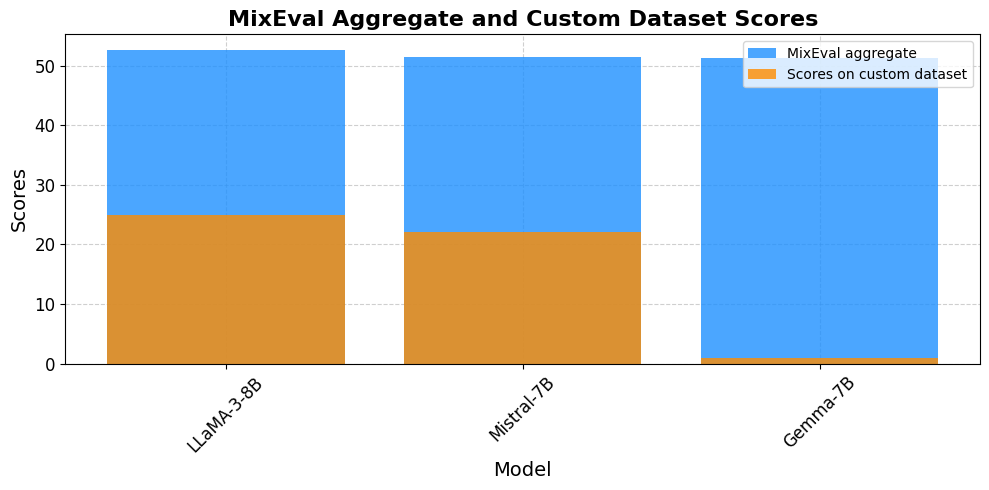

In [ ]:
import matplotlib.pyplot as plt

# mixeval data is taken from https://mixeval.github.io/
mixeval_data = {
    'Model': ['LLaMA-3-8B', 'Mistral-7B', 'Gemma-7B'],
    'Overall': [65.1, 64.8, 64.7],
    'HUM': [31.7, 27.1, 32.7],
    'STEM': [65.2, 67.2, 66.0],
    'SS': [69.5, 68.5, 67.4],
    'Other': [63.8, 61.3, 63.8],
    'China': [51.5, 54.5, 36.0],
    'Avg (high school)': [69.8, 67.9, 68.4],
    'Avg (college)': [64.0, 68.0, 74.3],
    'Avg (grad)': [22.6, 24.2, 31.1],
    'HS Knowledge': [38.5, 27.7, 28.1],
    'College Knowledge': [37.1, 34.5, 31.4]
}

# compute MixEval average score
mixeval_df = pd.DataFrame(mixeval_data)
mixeval_df['Average'] = mixeval_df.iloc[:, 1:].mean(axis=1)

aggregate_data = {
    'Model': ['LLaMA-3-8B', 'Mistral-7B','Gemma-7B'],
    'MixEval aggregate': [
                          mixeval_df.loc[mixeval_df['Model'] == 'LLaMA-3-8B', 'Average'].values[0],
                          mixeval_df.loc[mixeval_df['Model'] == 'Mistral-7B', 'Average'].values[0],
                          mixeval_df.loc[mixeval_df['Model'] == 'Gemma-7B', 'Average'].values[0]]
}


# Creating the custom dataset data (see Compare Candidate Models)
custom_dataset_data = {
    'Model': ['LLaMA-3-8B', 'Mistral-7B','Gemma-7B'],
    'Scores on custom dataset': [25, 22, 1]
}

# Convert to DataFrames
df_aggregate = pd.DataFrame(aggregate_data)
df_custom = pd.DataFrame(custom_dataset_data)

# Plotting the bar chart with enhanced colors
fig, ax = plt.subplots(figsize=(10, 5))

# Plot MixEval aggregate bars with enhanced color
bars_aggregate = ax.bar(df_aggregate['Model'], df_aggregate['MixEval aggregate'], color='dodgerblue', alpha=0.8, label='MixEval aggregate')

# Plot custom dataset bars with enhanced color
bars_custom = ax.bar(df_custom['Model'], df_custom['Scores on custom dataset'], color='darkorange', alpha=0.8, label='Scores on custom dataset')

# Adding title and labels
ax.set_title('MixEval Aggregate and Custom Dataset Scores', fontsize=16, fontweight='bold')
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.legend()

# Enhance the grid and ticks
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Display the plot with tight layout
plt.tight_layout()
plt.show()
